In [1]:
from gammapy.cube.fit import MapDatasetOnOff

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion
from gammapy.data import DataStore
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.detect import compute_lima_on_off_image
from gammapy.cube.ring import RingBackgroundEstimator
from gammapy.cube.make import MapMakerRing

# Testing the **MapDatasetOnOff**

## Generate some `counts`, `counts_off`, `acceptance`, `acceptance_off` images (using `MapMakerRing`)

In [3]:
data_store = DataStore.from_file(
    "/home/luca/GAMMAPY_DATA/hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)
data_sel = data_store.obs_table["TARGET_NAME"] == "MSH 15-52"
obs_table = data_store.obs_table[data_sel]
observations = data_store.get_observations(obs_table["OBS_ID"])

In [4]:
len(observations)

20

In [5]:
# pos_msh1552 = SkyCoord.from_name('MSH15-52')
pos_msh1552 = SkyCoord(228.32, -59.08, unit="deg")

In [6]:
energy_axis = MapAxis.from_edges(
    np.logspace(0, 5.0, 5), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=pos_msh1552,
    binsz=0.02,
    width=(5, 5),
    coordsys="CEL",
    proj="TAN",
    axes=[energy_axis],
)

In [7]:
regions = CircleSkyRegion(center=pos_msh1552, radius=0.3 * u.deg)
exclusion_mask = Map.from_geom(geom)
exclusion_mask.data = exclusion_mask.geom.region_mask([regions], inside=False)

In [8]:
ring_bkg = RingBackgroundEstimator(r_in="0.5 deg", width="0.3 deg")

In [9]:
%%time
im = MapMakerRing(
    geom=geom,
    offset_max=2.0 * u.deg,
    exclusion_mask=exclusion_mask,
    background_estimator=ring_bkg,
)
images = im.run_images(observations[0:10])

CPU times: user 6.36 s, sys: 226 ms, total: 6.59 s
Wall time: 6.59 s


In [10]:
images.keys()

dict_keys(['on', 'exposure_on', 'off', 'exposure_off', 'exposure'])

## Instanciate the `MapDatasetOnOff`

In [11]:
dataset = MapDatasetOnOff(
    model=None,
    counts=images["on"],
    counts_off=images["off"],
    acceptance=images["exposure_on"],
    acceptance_off=images["exposure_off"],
    exposure=images["exposure"],
    mask_fit=None,
    psf=None,
    edisp=None,
    name="",
    evaluation_mode="local",
    mask_safe=None,
    gti=None,
)

In [12]:
print(dataset)

MapDatasetOnOff

    Name                            :  

    Total counts                    : 10796 
    Total predicted counts          : nan
    Exposure min                    : 1.22e+09 m2 s
    Exposure max                    : 6.25e+09 m2 s

    Number of total bins            : 62500 
    Number of fit bins              : 62500 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : nan

    Number of models                : 0 
    Number of parameters            : 0
    Number of free parameters       : 0




In [13]:
dataset.parameters.parameters

[]

In [14]:
dataset.alpha

/home/luca/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (250, 250)
	ndim  : 2
	unit  : 
	dtype : float32

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fd734c426d8>)

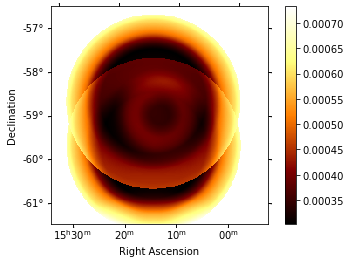

In [15]:
dataset.alpha.plot(add_cbar=True)

## Try stacking

In [16]:
energy_axis_other = energy_axis
geom_other = geom

im = MapMakerRing(
    geom=geom,
    offset_max=2.0 * u.deg,
    exclusion_mask=exclusion_mask,
    background_estimator=ring_bkg,
)
images = im.run_images(observations[10:19])

coords = geom_other.get_coord()
mask_safe = coords["energy"] > 0.3 * u.TeV

In [17]:
dataset_other = MapDatasetOnOff(
    model=None,
    counts=images["on"],
    counts_off=images["off"],
    acceptance=images["exposure_on"],
    acceptance_off=images["exposure_off"],
    exposure=images["exposure"],
    mask_fit=None,
    psf=None,
    edisp=None,
    name="",
    evaluation_mode="local",
    mask_safe=None,
    gti=None,
)

In [18]:
dataset_other.alpha

/home/luca/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (250, 250)
	ndim  : 2
	unit  : 
	dtype : float32

In [19]:
dataset.stack(dataset_other)

(<Figure size 1800x288 with 8 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fd73459b7f0>)

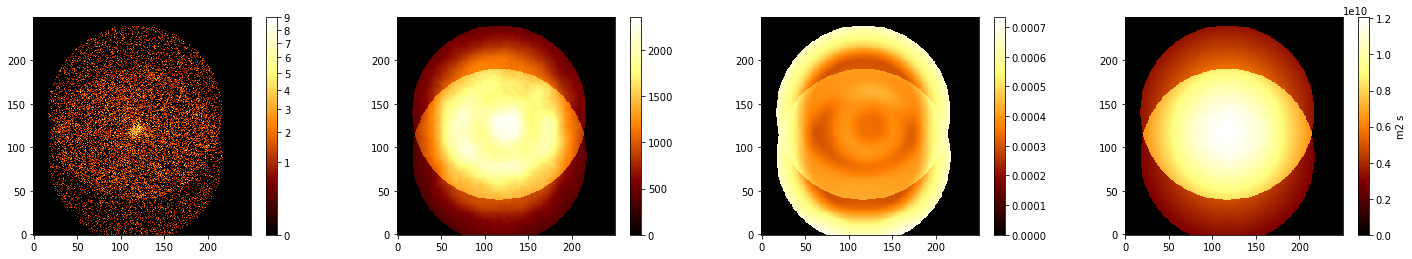

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))
dataset.counts.sum_over_axes().plot(add_cbar=True, stretch="sqrt", ax=axes[0])
dataset.counts_off.sum_over_axes().plot(add_cbar=True, ax=axes[1])
dataset.alpha.sum_over_axes().plot(add_cbar=True, ax=axes[2])
dataset.exposure.sum_over_axes().plot(add_cbar=True, ax=axes[3])

In order to check if the stacking is done correctly, we run the `MapMakerRing` for all the 20 observations and compare the results:

In [21]:
im = MapMakerRing(
    geom=geom,
    offset_max=2.0 * u.deg,
    exclusion_mask=exclusion_mask,
    background_estimator=ring_bkg,
)
images = im.run_images(observations)

(<Figure size 1800x288 with 8 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fd733303c88>)

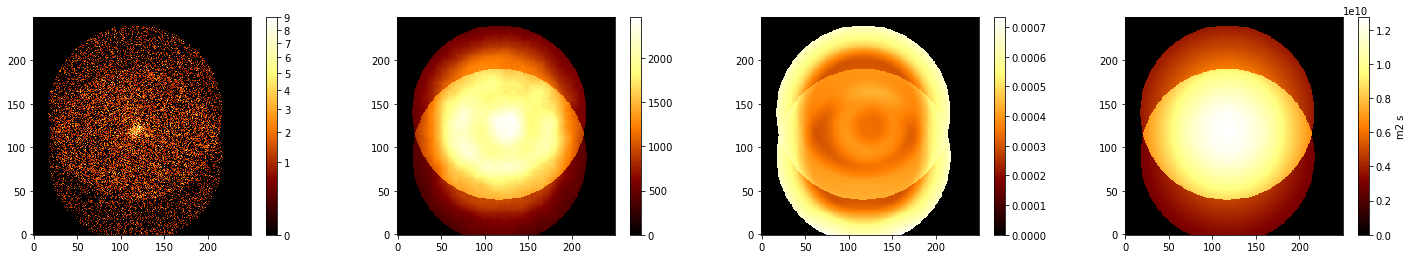

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))
images["on"].sum_over_axes().plot(add_cbar=True, stretch="sqrt", ax=axes[0])
images["off"].sum_over_axes().plot(add_cbar=True, ax=axes[1])

alpha = images["exposure_on"].sum_over_axes() / images["exposure_off"].sum_over_axes()
alpha.data[np.isnan(alpha.data)] = 0
alpha.plot(add_cbar=True, ax=axes[2])
images["exposure"].sum_over_axes().plot(add_cbar=True, ax=axes[3])

## Likelihood

In [23]:
dataset.likelihood_per_bin()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
dataset.likelihood_per_bin().sum()

40706.025152502

In [25]:
dataset.likelihood()

40706.025152502